<a href="https://colab.research.google.com/github/Buchiexplores/Notebooks/blob/master/ML_prediction_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PYTHON NOTEBOOK ON PROTOTYPING MACHINE LEARNING PREDICTION MODELS**
Written and compiled by **Abuchi Godswill Okeke**

Linkedin: https://www.linkedin.com/in/abuchi-okeke-67b48a105/

e-mail: abuchi.okeke@uky.edu

#Features:
* Upload files from google drive or local device drive
* Dimensional reduction and feature selection using PCA
* Cross-Validation to find best estimators
* Random forest Regressor
* K nearest neighbor Regressor
* Decision trees Regressor
* Support vector Regressor
* Partial Least Square Regression (PLSR)
* Ensemble learning
* Model evaluation (Validation curves, R_Squarred and RMSE)


In [0]:
#Importing data from local drive
import pandas as pd
from google.colab import files
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from yellowbrick.datasets import load_energy
from yellowbrick.model_selection import ValidationCurve
from sklearn.cross_decomposition import PLSRegression

# Plotting library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# tells matplotlib to embed plots within the notebook
%matplotlib inline
plt.style.use('ggplot')

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1KEfi5l6uE1iCcaxPlFozjrx3EBG40iwb'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('classification_resampled.csv')

In [0]:
uploaded = files.upload()


Saving bread_wavenumbers.csv to bread_wavenumbers.csv


In [0]:
#label_df = pd.read_csv(io.BytesIO(uploaded['Yclassification_label.csv']))
# Dataset is n#ow stored in a Pandas Dataframe

In [0]:
base_dir = '/content/';

In [72]:
data = np.loadtxt(base_dir + 'bread_samples.csv', delimiter=',');
y = np.loadtxt(base_dir + 'Ylabel.csv');
data.shape

(7468, 210)

In [76]:
wavenumbers = np.loadtxt(base_dir + 'bread_wavenumbers.csv', delimiter=',');
np.transpose(wavenumbers)[1].shape

(7468,)

Text(0, 0.5, 'Absorbances')

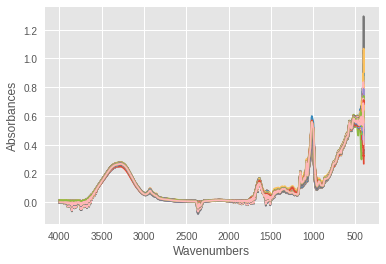

In [77]:
#Visualize data
plt.figure()
plt.gca().invert_xaxis()
plt.plot(np.transpose(wavenumbers)[1],data, '-')
plt.xlabel('Wavenumbers')
plt.ylabel('Absorbances')


#Dimensional reduction and feature selection using **PCA**

In [0]:
#PCA Dimensional Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import datasets

In [80]:
# Standardize the feature matrix
#data_rescaled = StandardScaler().fit_transform(data)
#data = np.transpose(data)
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(np.transpose(data))
data_rescaled.shape

(210, 7468)

In [0]:
#fit PCA
pca = PCA().fit(data_rescaled)

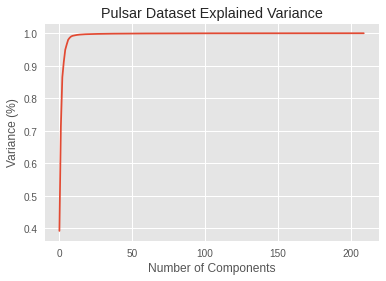

In [82]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [87]:
# Create a PCA that will retain 99% of the variance
pca = PCA(n_components=30, whiten=True)

#Conduct PCA
data_pca = pca.fit_transform(data_rescaled)
#wavenumbers_pca = pca.fit_transform(np.transpose(wavenumbers))
data_pca

array([[ 1.22663485, -0.35699495,  0.02494567, ..., -0.934452  ,
         1.68315207, -0.61014792],
       [ 1.15069105, -0.35755744,  0.08919571, ..., -0.29197896,
        -0.11970151, -0.8129857 ],
       [ 1.23443261, -0.31037791,  0.67300859, ...,  0.11065792,
         0.29280826, -0.30830057],
       ...,
       [ 0.56334778,  0.56352061, -0.18679337, ..., -0.36116863,
        -2.0704037 , -0.71843343],
       [ 0.47812161,  0.57590525, -0.19078889, ...,  1.19623339,
        -2.29319623, -0.32745487],
       [ 0.41397618,  0.56220603, -0.15964277, ..., -1.29238663,
        -0.1739767 , -0.68985194]])

In [93]:
#Show results
print('Original number of features:', data_rescaled.shape)
print('Reduced number of features:', data_pca.shape)
print('Number of labels:', y.shape)

Original number of features: (210, 7468)
Reduced number of features: (210, 30)
Number of labels: (210,)


##**Data Splitting**

In [95]:
train_sample, test_sample, train_label, test_label = train_test_split(data_pca, y, train_size=0.8,
        test_size=0.2, 
        # random but same for all run, also accuracy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=42
        # keep same proportion of 'target' in test and target data
        # stratify=targets  # can not used for single feature
        )

train_sample_plsr, test_sample_plsr, train_label_plsr, test_label_plsr = train_test_split(data_rescaled, y, train_size=0.8,
        test_size=0.2, random_state=42)
print(train_sample.shape)
print(test_sample.shape)
print(train_label.shape)
print(test_label.shape)
train_sample

(168, 30)
(42, 30)
(168,)
(42,)


array([[-1.93752881,  0.37584427, -1.14395154, ...,  0.49860599,
         1.8641555 ,  2.75085617],
       [-1.03007053,  0.47501139,  2.76032614, ...,  0.30055268,
        -1.04564709, -0.05903428],
       [ 0.43129362,  0.5741322 , -0.10687448, ..., -0.25458967,
         1.16161187, -2.71570995],
       ...,
       [-0.80721214,  0.75576914,  2.99542308, ...,  0.60078831,
         1.29018217,  0.35099739],
       [-0.70346125, -1.42870889, -0.58669507, ..., -1.07302286,
         1.67839178, -1.15409709],
       [-0.09845337, -0.16046701,  0.0604741 , ..., -0.89491319,
         0.62476872, -0.34427407]])

In [0]:
#Visualize data
#plt.figure()
#plt.plot(data, np.transpose(y), '.')
#plt.xlabel('Data');
#plt.ylabel('labels')

In [0]:
#Visualize data
#plt.figure()
#plt.plot(data_pca, np.transpose(y), '.')
#plt.xlabel('Data');
#plt.ylabel('labels')

##**Validation Curve Function**

Tunning the hyper-parameters of each estimators help to determine how well our learning algorithm performs. The function below validates the learning scores against any given range of estimator parameter. If the training score and the validation score are both low, the estimator will be underfitting. If the training score is high and the validation score is low, the estimator is overfitting and otherwise it is working very well. A low training score and a high validation score is usually not possible. All three cases can be observed using the function below.



In [0]:


def validate_estimator (X,y,estimator,estimator_name,para_name,para_range,x_label):
 
  #scoring="neg_mean_squared_error"
  train_scores, test_scores = validation_curve(estimator, X, y, param_name=para_name,scoring="r2",param_range=para_range,cv=5)
  train_scores_mean = np.mean((1+train_scores), axis=1)
  train_scores_std = np.std((1+train_scores), axis=1)
  test_scores_mean = np.mean((1+test_scores), axis=1)
  test_scores_std = np.std((1+test_scores), axis=1)

  plt.title("Validation Curve for %s" % estimator_name)
  plt.xlabel("%s" % x_label)
  plt.ylabel("Score")
  plt.ylim(0.0, 3)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
  plt.legend(loc="best")
  return plt.show()

In [0]:
# def yellow_validate(X,y,estimator,para_name,param_range):

#   viz = ValidationCurve(
#     estimator, param_name=para_name,
#     param_range=param_range, cv=10, scoring="r2"
#   )

#   # Fit and show the visualizer
#   viz.fit(X, y)
#   return viz.show()


#**Parameter Search:**
Loops through range of parameters using cross-validation to obtain the value with minimum  mean squared error (optimal parameter).


In [0]:
#Cross-validation
#find the best n_estimators

estimators = list(range(1, 1000,10))
#estimators = list(np.arange(0.0001,0.001,0.0001))
# empty list that will hold cv scores
cv_scores = []
cv_r2 = []

# perform 10-fold cross validation
for k in estimators:
    Rf = RandomForestRegressor(n_estimators=k, criterion='mse', max_depth=k, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=-1, random_state=500, verbose=0, warm_start=False)

    #scores = cross_val_score(Rf, train_sample, train_label.ravel(), scoring=('r2','neg_mean_squared_error'), cv=10)
    scores_cv = cross_validate(Rf, train_sample, train_label, groups=None, scoring=('r2','neg_mean_squared_error'), cv=10, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=True, return_estimator=False)
    print(scores_cv['test_neg_mean_squared_error'])
    print(scores_cv['train_r2'])
    cv_r2.append(scores_cv['train_r2'].mean())
    cv_scores.append(np.mean(list(scores_cv.values())))
    #cv_scores.append(scores_cv.mean())
    

The optimal number of estimators is 991
The optimal number of estimators r2 is 1.0


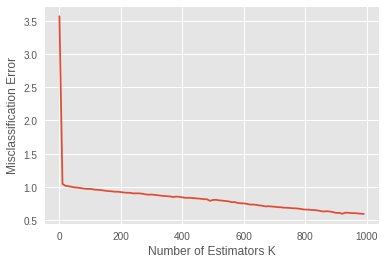

In [0]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = estimators[mse.index(min(mse))]
opt_r2 = cv_r2[mse.index(min(mse))]
print("The optimal number of estimators is {}".format(optimal_k))
print("The R_Squared for optimal number of estimator is {}".format(opt_r2))

# plot misclassification error vs k
plt.plot(estimators, mse)
plt.xlabel("Number of Estimators K")
plt.ylabel("Misclassification Error")
plt.show()

#**Learning Algorithms**
Random forest, K-nearest neighbors, Decision tree, support vector machine and ensemble learning (Voting method). The ensemble method is use depending on the performance of individual learning algorithm. If a single learning algorithm outperfoms others, the use of the ensemble method will be ignored.


#**Model Evaluation**
* RMSE
* R_Squared
* Validation curve

The test data indicates how well your model has generalized. The test data is use to validate how good your model is.

Using machine learning method, it is very common to present both the validation and the test accuracy (R_Squared), but the most important is the test accuracy.

During the process of training and you get a significant lower 𝑅2 score on test, and not the training, then something is not adding up. If the 𝑅2test is far less than 𝑅2 training, then it indicates that your model does not generalize well. That is, if you subject your model to future test set data points it would not extrapolate very well and thus, the performance of the model will be poor.  

**In conclusion:** focus should be on the result from the test set scores/accuracy/R_squared rather than that of the training set.




#**Random Forest Regressor**

R_Squared_Prediction:  0.5159485556526493
RMSEP: 2.0642947619029353
RMSET: 0.0


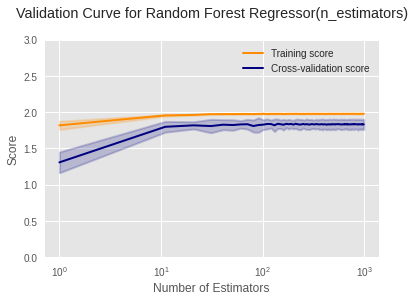

R2_T/Train_Score: 1.0
R2_P/Test_Score: 0.5159485556526493


In [97]:
#Random Forest Regressor
clf = RandomForestRegressor(n_estimators=991, criterion='mse', max_depth=10, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=-1, random_state=500, verbose=0, warm_start=False)
clf.fit(train_sample, train_label)

predsRf_test = clf.predict(test_sample)
#print(clf.score(X_train, y_train))

r2_rf = r2_score(test_label, predsRf_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_rf)
mse_rf_test= mean_squared_error(test_label.ravel(), predsRf_test.ravel())
rmsep = np.sqrt(mse_rf_test)
print("RMSEP:", rmsep)

predsRf_train = clf.predict(train_sample)
mse_rf_train= mean_squared_error(train_label.ravel(), predsRf_train.ravel())
rmset = np.sqrt(mse_rf_train)
print("RMSET:", rmset)

param_range = list(range(1, 1000,10))
estimator = RandomForestRegressor()
estimator_name = "Random Forest Regressor(n_estimators)\n"
validate_estimator(train_sample,train_label,estimator,estimator_name,"n_estimators",param_range, "Number of Estimators")

train_score = clf.score(train_sample, train_label)
test_score = clf.score(test_sample, test_label)
print("R2_T/Train_Score:", train_score)
print("R2_P/Test_Score:", test_score)




#**K-Nearest Neighbors**

R_Squared_Prediction:  0.9871955342337846
RMSEP: 0.33574277994577084
RMSET: 0.4179296335167304


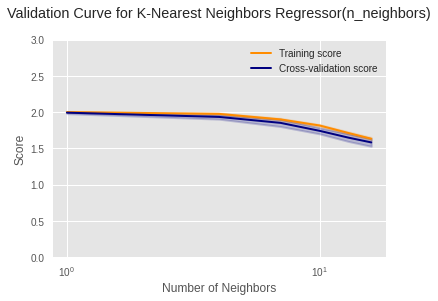

R2_T/Train_Score: 0.9809641399110135
R2_P/Test_Score: 0.9871955342337846


In [98]:
#KNeighbors Regressor

##METRIC:
#euclidean
#manhattan
#hamming
#minkowski

knn = KNeighborsRegressor(n_neighbors=4, weights='uniform', algorithm='auto', leaf_size=1, p=2, metric='manhattan', metric_params=None, n_jobs=-1)
knn.fit(train_sample, train_label)
predsKNN_test = knn.predict(test_sample)
predsKNN_train = knn.predict(train_sample)

scores_cv = cross_validate(knn, train_sample, train_label, groups=None, scoring=('r2','neg_mean_squared_error'), cv=10, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=True, return_estimator=False)
#print(np.mean(list(scores_cv.values())))
#print(scores_cv['test_neg_mean_squared_error'].mean())
#print(scores_cv['train_r2'].mean())

r2_knn = r2_score(test_label, predsKNN_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_knn)
mse_KNN_test= mean_squared_error(test_label.ravel(), predsKNN_test.ravel())
rmsep = np.sqrt(mse_KNN_test)
print("RMSEP:", rmsep)

mse_knn_train= mean_squared_error(train_label.ravel(), predsKNN_train.ravel())
rmset = np.sqrt(mse_knn_train)
print("RMSET:", rmset)

param_range = list(range(1, 18,3))
estimator = KNeighborsRegressor()
estimator_name = "K-Nearest Neighbors Regressor(n_neighbors)\n"
validate_estimator (train_sample,train_label,estimator, estimator_name,"n_neighbors",param_range, "Number of Neighbors")

train_score = knn.score(train_sample, train_label)
test_score = knn.score(test_sample, test_label)
print("R2_T/Train_Score:", train_score)
print("R2_P/Test_Score:", test_score)



#**Decision Tree**

R_Squared_Prediction:  0.5461213080547652
RMSEP: 1.9989219992873655
RMSET: 0.2874163586415722


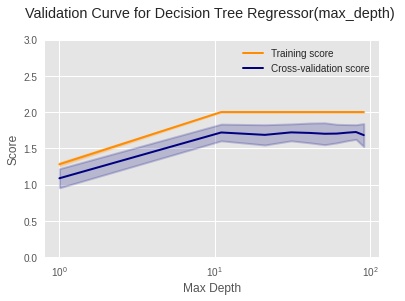

R2_train/Train_Score: 0.990996960870929
R2_test/Test_Score: 0.5461213080547652


In [99]:
#Decision Tree

dct = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=6, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
dct.fit(train_sample, train_label)
predTree_test = dct.predict(test_sample)

predTree_train = dct.predict(train_sample)
r2_dct = r2_score(test_label, predTree_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_dct)
mse_tree_test= mean_squared_error(test_label.ravel(), predTree_test.ravel())
rmsep = np.sqrt(mse_tree_test)
print("RMSEP:", rmsep)

mse_tree_T= mean_squared_error(train_label.ravel(), predTree_train.ravel())
rmset = np.sqrt(mse_tree_T)
print("RMSET:", rmset)

param_range = list(range(1, 100,10))
#param_range = np.logspace(-6, -1, 5)
estimator = DecisionTreeRegressor()
estimator_name = "Decision Tree Regressor(max_depth) \n"
validate_estimator (train_sample,train_label,estimator,estimator_name,"max_depth",param_range, "Max Depth")

train_score = dct.score(train_sample, train_label)
test_score = dct.score(test_sample, test_label)
print("R2_train/Train_Score:", train_score)
print("R2_test/Test_Score:", test_score)


#**Support Vector Machine**

R_Squared_Prediction:  0.7549603561400244
RMSEP: 1.4687373079323327
RMSET: 0.977404968846549
Accuracy for test data: 0.7549603561400244


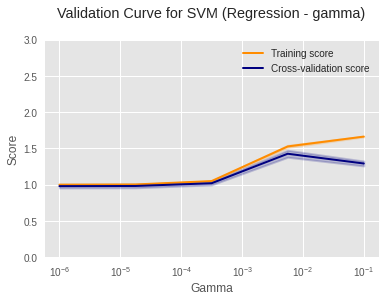

R2_T/Train_Score: 0.8958845316776596
R2_P/Test_Score: 0.7549603561400244


In [100]:
from sklearn.svm import SVR

# training using 'training data'
sv_reg = SVR(kernel='rbf', degree=3, gamma=0.03, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
sv_reg.fit(train_sample, train_label) # fit the model for training data
# predict the 'target' for 'test data'
predsSVR_test = sv_reg.predict(test_sample)

scores_cv = cross_validate(sv_reg, train_sample, train_label, groups=None, scoring=('r2','neg_mean_squared_error'), cv=10, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=True, return_estimator=False)
#print(np.mean(list(scores_cv.values())))
#print(scores_cv['test_neg_mean_squared_error'].mean())
#print(scores_cv['train_r2'].mean())

predsSVR_train = sv_reg.predict(train_sample)
r2_svr = r2_score(test_label, predsSVR_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_svr)
mse_SVR_test= mean_squared_error(test_label.ravel(), predsSVR_test.ravel())
rmsep = np.sqrt(mse_SVR_test)
print("RMSEP:", rmsep)

mse_SVR_T= mean_squared_error(train_label.ravel(), predsSVR_train.ravel())
rmset = np.sqrt(mse_SVR_T)
print("RMSET:", rmset)

test_accuracy = sv_reg.score(test_sample, test_label)
print("Accuracy for test data:", test_accuracy)

#param_range = list(range(1, 18,3))
param_range = np.logspace(-6, -1, 5)
estimator = SVR()
estimator_name = "SVM (Regression - gamma)\n"
validate_estimator (train_sample,train_label,estimator,estimator_name,"gamma",param_range, "Gamma")

train_score = sv_reg.score(train_sample, train_label)
test_score = sv_reg.score(test_sample, test_label)
print("R2_T/Train_Score:", train_score)
print("R2_P/Test_Score:", test_score)


#**Partial Least Square Regression (PLSR)**

R_Squared_Prediction:  0.9693760942132166
RMSEP: 0.5192257715994915
RMSET: 0.07908921739088881
Accuracy for test data: 0.9693760942132165


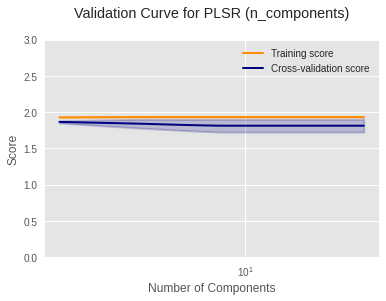

R2_T/Train_Score: 0.9993182883307736
R2_P/Test_Score: 0.9693760942132165


In [103]:
plsr = PLSRegression(n_components=30, scale=True, max_iter=500, tol=1e-06, copy=True)
plsr.fit(train_sample_plsr, train_label_plsr) # fit the model for training data
# predict the 'target' for 'test data'
predsplsr_test = plsr.predict(test_sample_plsr)

scores_cv = cross_validate(plsr, train_sample_plsr, train_label_plsr, groups=None, scoring=('r2','neg_mean_squared_error'), cv=10, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=True, return_estimator=False)
#print(np.mean(list(scores_cv.values())))
#print(scores_cv['test_neg_mean_squared_error'].mean())
#print(scores_cv['train_r2'].mean())

predsplsr_train = plsr.predict(train_sample_plsr)
r2_plsr = r2_score(test_label_plsr, predsplsr_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_plsr)
mse_plsr_test= mean_squared_error(test_label_plsr.ravel(), predsplsr_test.ravel())
rmsep = np.sqrt(mse_plsr_test)
print("RMSEP:", rmsep)

mse_plsr_T= mean_squared_error(train_label_plsr.ravel(), predsplsr_train.ravel())
rmset = np.sqrt(mse_plsr_T)
print("RMSET:", rmset)

test_accuracy = plsr.score(test_sample_plsr, test_label_plsr)
print("Accuracy for test data:", test_accuracy)

param_range = list(range(2,30,2))
#param_range = np.logspace(-6, -1, 5)
estimator = plsr
estimator_name = "PLSR (n_components)\n"
validate_estimator (train_sample,train_label,estimator,estimator_name,"n_components",param_range,"Number of Components")

train_score = plsr.score(train_sample_plsr, train_label_plsr)
test_score = plsr.score(test_sample_plsr, test_label_plsr)
print("R2_T/Train_Score:", train_score)
print("R2_P/Test_Score:", test_score)

#**Ensemble Learning**

In [0]:
from sklearn.ensemble import VotingRegressor
model1 = clf
model2 = knn
model3 = dct
model4 = sv_reg
model5 = plsr

model = VotingRegressor(estimators=[('rf', model1), ('kn', model2), ('dc', model3), ('sv', model4), ('pl', model5)], weights=None, n_jobs=None)
model.fit(train_sample,train_label)
model.score(test_sample,test_label)
preds_test = model.predict(test_sample)

r2_voting = r2_score(test_label, preds_test, sample_weight=None, multioutput='uniform_average')
print("R_Squared_Prediction: ", r2_voting)
mse_voting_test= mean_squared_error(test_label.ravel(), preds_test.ravel())
rmsep = np.sqrt(mse_voting_test)
print("RMSEP:", rmsep)

preds_train = model.predict(train_sample)
mse_voting_training= mean_squared_error(train_label.ravel(), preds_train.ravel())
rmset = np.sqrt(mse_voting_training)
print("RMSET:", rmset)

train_score = model.score(train_sample, train_label)
test_score = model.score(test_sample, test_label)
print("R2_T/Train_Score:", train_score)
print("R2_P/Test_Score:", test_score)


R_Squared_Prediction:  0.8110067314813709
RMSEP: 1.2898794339637534
RMSET: 0.29878931303058853
R2_T/Train_Score: 0.990270370755581
R2_P/Test_Score: 0.8110067314813709
